In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import time
import amt.method as md
import amt.data_loader as dl
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [100]:
output_folder = '/home/martin/adapative_MC_test/results/schematic'
output_figure_folder = '/home/martin/adapative_MC_test/figures/figure_schema'
# output_file = output_folder + '/simulation_alpha.pickle'
n_hypothesis = 50
alpha = 0.25
n_fMC = 1000
method_list = ['fmc', 'smc50', 'smc100', 'amt']

In [101]:
p_exact, h = dl.load_demo_data(n_hypothesis=n_hypothesis, pi1=0.4, 
                               effect_size=2.5, random_state=0)
tau_exact = md.bh(p_exact, alpha=alpha)
h_exact = (p_exact <= tau_exact)
# fMC p-values and MC samples
np.random.seed(1)
start_time = time.time()
B, p_fmc, t_fmc = md.get_monte_carlo_sample(p_exact, n_permutation=n_fMC)
tau_fmc = md.bh(p_fmc, alpha=alpha)
h_fmc = (p_fmc <= tau_fmc)
print('# fMC: avg. MC samples = %d, time=%0.2fs'%(np.mean(n_fMC),
                                                  time.time()-start_time))
print('# discoveries=%d, fdp=%0.3f, power=%0.3f'%(np.sum(h_fmc),
                                                  np.sum(h_fmc&(~h))/np.sum(h_fmc),
                                                  np.sum(h_fmc&(h))/np.sum(h)))
print('')

# fMC: avg. MC samples = 1000, time=0.01s
# discoveries=24, fdp=0.333, power=0.800



In [102]:
start_time = time.time()
p_hat_ub, p_hat_lb, p_hat, tau_hat, n_amt = md.amt(md.f_sample_dummy, B,
                                                   n_hypothesis,
                                                   alpha=alpha, n_fMC=n_fMC,
                                                   batch_size_start=10,
                                                   output_folder = output_folder,
                                                   verbose=True, 
                                                   output_data_folder=output_folder)
h_amt = (p_hat_ub <= tau_hat)
print('# AMT: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_amt),
                                                     time.time()-start_time))
print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_amt, h_fmc)))
print('')

# Initialization parameters
# n_hypothesis=50, n_fMC=1000, alpha=0.25, increment=1.10
# delta 0.02
# delta_CI 5.790593092043358e-05
# r_hat=50, tau_hat=0.2500
# batch_size [10 11 13 14 15 17 18 20 22 24 26 29 32 35 38 42 46 51 56 62 68 75 82 90
 99  5]
# sum of batch size = 1000
# Initialization completed: time=-0.004s
# 0, avg_sample=10.0, tau=0.23500, r_hat=47, n_u=47, n_g=3, n_l=0
# 1, avg_sample=20.3, tau=0.22000, r_hat=44, n_u=44, n_g=6, n_l=0
# 2, avg_sample=31.8, tau=0.20500, r_hat=41, n_u=41, n_g=9, n_l=0
# 3, avg_sample=43.3, tau=0.20500, r_hat=41, n_u=41, n_g=9, n_l=0
# 4, avg_sample=55.6, tau=0.18500, r_hat=37, n_u=37, n_g=13, n_l=0
# 5, avg_sample=68.1, tau=0.16500, r_hat=33, n_u=33, n_g=17, n_l=0
# 6, avg_sample=80.0, tau=0.16500, r_hat=33, n_u=33, n_g=17, n_l=0
# 7, avg_sample=93.2, tau=0.16500, r_hat=33, n_u=22, n_g=17, n_l=11
# 8, avg_sample=102.9, tau=0.16500, r_hat=33, n_u=18, n_g=17, n_l=15
# 9, avg_sample=111.5, tau=0.16500, r_hat=33, n_u=16, n_g=17, n_l=17
# 10, av

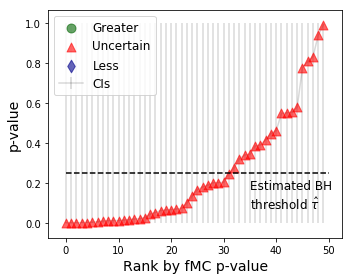

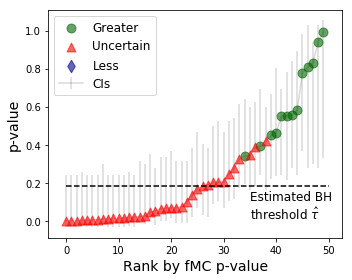

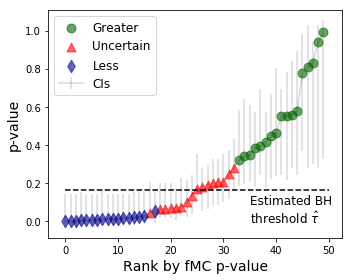

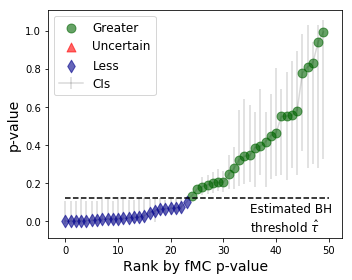

In [220]:
f_list = ['init', 'itr5', 'itr10', 'final']
for fname in f_list:
    # with open(output_folder+'/init.pickle', 'rb')as f:
    # with open(output_folder+'/itr20.pickle', 'rb')as f:
    # with open(output_folder+'/final.pickle', 'rb')as f:
    with open(output_folder+'/%s.pickle'%fname, 'rb')as f:
        res_dic = pickle.load(f)
    #     'p_hat_ub':p_hat_ub, 'p_hat_lb':p_hat_lb, 
    #     'n_amt':n_amt, 's_amt': s_amt, 'ind_sample':ind_sample,
    #     'r_hat':r_hat, 'tau_hat':tau_hat}
    xaxis = np.arange(n_hypothesis)
    ind_sort = np.argsort(p_fmc)
    plt.figure(figsize=(5,4))
    y_err = np.zeros([2,n_hypothesis], dtype=float)
    y_err[0,:] = p_fmc - res_dic['p_hat_lb']
    y_err[1,:] = res_dic['p_hat_ub'] - p_fmc
    plt.errorbar(xaxis, p_fmc[ind_sort], yerr = y_err[:, ind_sort], alpha=0.15,
                 color = 'k', zorder=0, label='CIs')
#     plt.plot(p_fmc[ind_sort], marker='o', linestyle='dashed', alpha=0.4,
#              color='steelblue', zorder=1)
    # Greater
    temp = ((~res_dic['ind_sample'])&
            (res_dic['p_hat_lb']>res_dic['tau_hat']))[ind_sort]
    plt.scatter(xaxis[temp], p_fmc[ind_sort][temp],
                color='darkgreen', alpha=0.6, zorder=2, label='Greater',
                marker='o', s=80)
    # Uncertain
    temp = res_dic['ind_sample'][ind_sort]
    plt.scatter(xaxis[temp], p_fmc[ind_sort][temp],
                color='r', alpha=0.6, zorder=2, label='Uncertain',
                marker='^', s=80)
    # Less
    temp = ((~res_dic['ind_sample'])&
            (res_dic['p_hat_ub']<=res_dic['tau_hat']))[ind_sort]
    plt.scatter(xaxis[temp], p_fmc[ind_sort][temp],
                color='darkblue', alpha=0.6, zorder=2, label='Less',
                marker='d', s=80)
    plt.plot([0, n_hypothesis], [res_dic['tau_hat'], res_dic['tau_hat']],
             color='k', linestyle='--')
    plt.annotate('Estimated BH \nthreshold $\hat{\\tau}$', 
                 (35, res_dic['tau_hat']-0.17),
                 fontsize=12)
    plt.legend(fontsize=12)
    plt.ylabel('p-value', fontsize=14)
    plt.xlabel('Rank by fMC p-value', fontsize=14)
    output_fig_file = output_figure_folder + '/%s'%fname
    plt.tight_layout()
    plt.savefig(output_fig_file+'.png')
    plt.savefig(output_fig_file+'.pdf')
    plt.show()

# Comparison with sMC 

In [197]:
t_fmc

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000])

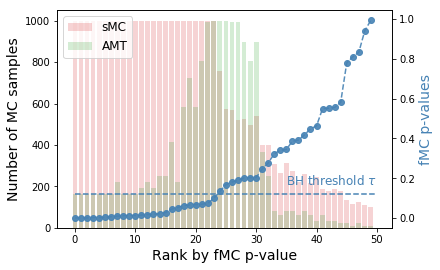

In [218]:
p_smc, n_smc = md.sMC(B, r=100)
tau_smc = md.bh(p_smc, alpha=alpha)
h_smc = (p_smc <= tau_smc)
ind_sort = np.argsort(p_fmc)
xaxis = np.arange(n_hypothesis)
with open(output_folder+'/%s.pickle'%'final', 'rb')as f:
    res_dic = pickle.load(f)
# plt.figure()
fig, ax1 = plt.subplots()
ax1.bar(xaxis, n_smc[ind_sort], alpha=0.2, color='C3', label='sMC')
# ax1.bar(xaxis, n_smc[ind_sort], alpha=0.1, color='k', label='sMC')
ax1.bar(xaxis, res_dic['n_amt'][ind_sort], alpha=0.2, color='C2', label='AMT')
# ax1.bar(xaxis, res_dic['n_amt'][ind_sort], alpha=0.4, color='k', label='AMT')
# plt.plot(p_fmc[ind_sort]*1000, marker='o', linestyle='dashed', alpha=0.4,
#          color='steelblue', zorder=1)
ax1.legend(fontsize=12, loc='upper left')
ax1.set_ylabel('Number of MC samples', fontsize=14)
ax1.set_xlabel('Rank by fMC p-value', fontsize=14)

ax2 = ax1.twinx()
s2 = np.sin(2 * np.pi * t)
ax2.plot(p_fmc[ind_sort], marker='o', linestyle='dashed', alpha=0.9,
         color='steelblue', zorder=1)
ax2.plot([0, n_hypothesis], [tau_fmc, tau_fmc],
         color='steelblue', linestyle='--')
ax2.set_ylabel('fMC p-values', color='steelblue', fontsize=14)
plt.annotate('BH threshold $\\tau$', 
             (35, tau_fmc+0.05),
             fontsize=12, color='steelblue')
# plt.ylabel('Number of MC sampels', fontsize=14)
# plt.xlabel('Rank by fMC p-value', fontsize=14)
output_fig_file = output_figure_folder + '/%s'%'compare'
plt.savefig(output_fig_file+'.png')
plt.savefig(output_fig_file+'.pdf')
plt.show()

In [219]:
output_figure_folder

'/home/martin/adapative_MC_test/figures/figure_schema'

In [200]:
res_dic['tau_hat']

0.12

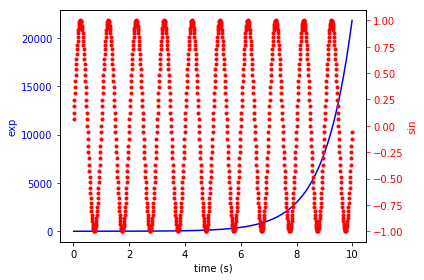

In [180]:
fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('exp', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = np.sin(2 * np.pi * t)
ax2.plot(t, s2, 'r.')
ax2.set_ylabel('sin', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

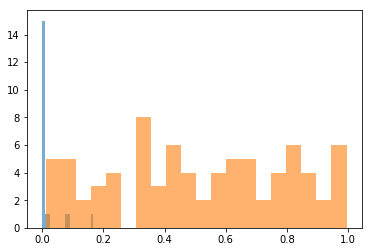

In [20]:
plt.figure()
plt.hist(p_exact[h],bins=20, alpha=0.6)
plt.hist(p_exact[~h],bins=20, alpha=0.6)
plt.show()

In [ ]:
p_exact, h = dl.load_demo_data(n_hypothesis=n_hypothesis, pi1=0.2, 
                                       effect_size=2.5, random_state=i_rep)
tau_exact = md.bh(p_exact, alpha=alpha)
h_exact = (p_exact <= tau_exact)
# fMC p-values and MC samples
start_time = time.time()
B, p_fmc, t_fmc = md.get_monte_carlo_sample(p_exact, n_permutation=n_fMC)
tau_fmc = md.bh(p_fmc, alpha=alpha)
h_fmc = (p_fmc <= tau_fmc)
res_dic['fmc']['n_MC_avg'][i_alpha,i_rep] = n_fMC
res_dic['fmc']['power'][i_alpha,i_rep] = np.sum(h_fmc&h)/np.sum(h)
res_dic['fmc']['fdp'][i_alpha,i_rep] = np.sum(h_fmc&(~h))/np.sum(h_fmc)
res_dic['fmc']['time'][i_alpha,i_rep] = time.time()-start_time
print('# fMC: avg. MC samples = %d, time=%0.2fs'%(np.mean(n_fMC),
                                                  time.time()-start_time))
print('')
# AMT 
start_time = time.time()
p_hat_ub, p_hat, tau_hat, n_amt = md.amt(md.f_sample_dummy, B, n_hypothesis,
                                  alpha=alpha, n_fMC=n_fMC,
                                  verbose=False)
h_amt = (p_hat_ub <= tau_hat)
res_dic['amt']['n_MC_avg'][i_alpha,i_rep] = np.mean(n_amt)
res_dic['amt']['power'][i_alpha,i_rep] = np.sum(h_amt&h)/np.sum(h)
res_dic['amt']['fdp'][i_alpha,i_rep] = np.sum(h_amt&(~h))/np.sum(h_amt)
res_dic['amt']['time'][i_alpha,i_rep] = time.time()-start_time
print('# AMT: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_amt),
                                                     time.time()-start_time))
print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_amt, h_fmc)))
print('')
# smc50
start_time = time.time()
p_smc, n_smc = md.sMC(B, r=50)
tau_smc = md.bh(p_smc, alpha=alpha)
h_smc = (p_smc <= tau_smc)
res_dic['smc50']['n_MC_avg'][i_alpha,i_rep] = np.mean(n_smc)
res_dic['smc50']['power'][i_alpha,i_rep] = np.sum(h_smc&h)/np.sum(h)
res_dic['smc50']['fdp'][i_alpha,i_rep] = np.sum(h_smc&(~h))/np.sum(h_smc)
res_dic['smc50']['time'][i_alpha,i_rep] = time.time()-start_time
print('# sMC50: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_smc),
                                                     time.time()-start_time))
print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_smc, h_fmc)))
print('')
# smc100
start_time = time.time()
p_smc, n_smc = md.sMC(B, r=100)
tau_smc = md.bh(p_smc, alpha=alpha)
h_smc = (p_smc <= tau_smc)
res_dic['smc100']['n_MC_avg'][i_alpha,i_rep] = np.mean(n_smc)
res_dic['smc100']['power'][i_alpha,i_rep] = np.sum(h_smc&h)/np.sum(h)
res_dic['smc100']['fdp'][i_alpha,i_rep] = np.sum(h_smc&(~h))/np.sum(h_smc)
res_dic['smc100']['time'][i_alpha,i_rep] = time.time()-start_time
print('# sMC100: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_smc),
                                                     time.time()-start_time))
print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_smc, h_fmc)))
print('')